# Centrality Dependence of nPDF Effects

## Setup, Import & Preprocess

In [37]:
import torch, numpy as np
print("Torch:", torch.__version__, "CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")

Torch: 2.9.0+cu126 CUDA available: True
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU


In [38]:
# --- setup (nPDF only) ---
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("./npdf_code")
## imports
from npdf_data_fast   import NPDFSystem, RpAAnalysis, centers_to_left_edges
from npdf_data_fast   import step_band_xy, style_axes, note_box, step_band_from_left_edges
from gluon_ratio_fast import EPPS21Ratio, GluonEPPSProvider
from glauber          import OpticalGlauber, SystemSpec

# ----------------------- user knobs -----------------------
P5_DIR   = "./input/npdf/pPb5TeV"
P8_DIR   = "./input/npdf/pPb8TeV"
EPPS_DIR = "./input/npdf/nPDFs"
OUTDIR   = Path("./output-npdf-comparisons"); OUTDIR.mkdir(exist_ok=True)

SQRTS   = { "5.02": 5023.0, "8.16": 8160.0 }
SIG_NN  = { "5.02": 67.0,   "8.16": 71.0 }

CENT_EDGES = [0,20,40,60,80,100]
Y_WINDOWS  = [(-4.46,-2.96,"Backward"), (-1.37,0.43,"Mid"), (2.03,3.53,"Forward")]
PT_RANGE   = (0.0, 20.0)
PT_FLOOR   = 1.5

COL = {"5.02":"tab:blue", "8.16":"tab:red"}
plt.rcParams.update({"figure.dpi":150, "font.size":12})

# ----------------------- EPPS providers -------------------
epps5 = GluonEPPSProvider(EPPS21Ratio(A=208, path=EPPS_DIR),
                          sqrt_sNN_GeV=SQRTS["5.02"], m_state_GeV="charmonium",
                          y_sign_for_xA=-1).with_geometry()

epps8 = GluonEPPSProvider(EPPS21Ratio(A=208, path=EPPS_DIR),
                          sqrt_sNN_GeV=SQRTS["8.16"], m_state_GeV="charmonium",
                          y_sign_for_xA=-1).with_geometry()

# ----------------------- Glauber systems ------------------
# (No module changes needed; these just provide centrality, b-PDF, etc.)

gl5 = OpticalGlauber(SystemSpec("pA", SQRTS["5.02"], A=208, sigma_nn_mb=SIG_NN["5.02"]))
gl8 = OpticalGlauber(SystemSpec("pA", SQRTS["8.16"], A=208, sigma_nn_mb=SIG_NN["8.16"]))

# ----------------------- Load TopDrawer & align grids -----
ana = RpAAnalysis()

sys5 = NPDFSystem.from_folder(P5_DIR, kick="pp", name="p+Pb 5.02 TeV", num_workers=os.cpu_count())
r5   = ana.compute_rpa_grid(sys5.df_pp, sys5.df_pa, sys5.df_errors,
                            pt_shift_min=0, shift_if_r_below=0.0,
                            lowpt_policy="drop", join="intersect")

sys8 = NPDFSystem.from_folder(P8_DIR, kick="pp", name="p+Pb 8.16 TeV", num_workers=os.cpu_count())
r8   = ana.compute_rpa_grid(sys8.df_pp, sys8.df_pa, sys8.df_errors,
                            pt_shift_min=0, shift_if_r_below=0.0,
                            lowpt_policy="drop", join="intersect")

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7718.37 mb, σ_tot^pA ≈ 1909.03 mb
[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb


In [49]:
# --- EPPS21/Gluon provider: force same-device tensors and GPU fast-path ----
import numpy as np, torch, types
import gluon_ratio_fast as grf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _as_t(x, like=None):
    """Return torch tensor on DEVICE (and same dtype as `like` if given)."""
    if torch.is_tensor(x):
        return x.to(device=DEVICE, dtype=(like.dtype if (like is not None) else x.dtype))
    x = np.asarray(x, dtype=np.float32)
    return torch.as_tensor(x, device=DEVICE, dtype=(like.dtype if (like is not None) else torch.float32))

def _as_np(x):
    return x.detach().cpu().numpy() if torch.is_tensor(x) else np.asarray(x, dtype=float)

# Patch: EPPS21Ratio._neville4_t must run with *all* args on the same device
def _neville4_t_patched(self, fNx4, xNx4, zN):
    # Ensure everything is on the same device/dtype
    fNx4 = _as_t(fNx4)
    xNx4 = _as_t(xNx4, like=fNx4)
    zN   = _as_t(zN,   like=fNx4)

    P = fNx4.clone()  # shape (...,4)
    for j in range(1, 4):
        for i in range(0, 4 - j):
            num = (zN - xNx4[:, i + j]) * P[:, i] + (xNx4[:, i] - zN) * P[:, i + 1]
            den = (xNx4[:, i] - xNx4[:, i + j])
            P[:, i] = num / den
    return P[:, 0]

# Patch the method
grf.EPPS21Ratio._neville4_t = _neville4_t_patched

# Small helpers used inside the fast path (if not already present in your file)
def _np(x):  # always numpy
    return _as_np(x)
def _same(ref, arr):  # keep type/shape flavour of ref (numpy in plotting)
    return _as_np(arr) if not torch.is_tensor(ref) else arr

# Patch ratio() tensor path to keep everything on one device
_old_ratio = grf.EPPS21Ratio.ratio
def _ratio_same_device(self, flav, x, Q, set=1):
    # Use the fast tensor path if available in your file; otherwise fall back to original.
    try:
        xb = _as_t(x)
        Qb = _as_t(Q, like=xb)
        out = torch.empty_like(xb, dtype=torch.float32, device=DEVICE)
        # The original fast implementation in gluon_ratio_fast builds
        # xb1, qb1, argx, argq and calls self._neville4_t(...).
        # We reuse the module's existing code by calling the original function
        # but first ensuring numpy inputs so it takes the fast-tensor route it defines.
        # If your original uses pure tensors already, this wrapper is harmless.
        return _old_ratio(self, flav, _as_np(xb), _as_np(Qb), set=set)
    except Exception:
        return _old_ratio(self, flav, x, Q, set=set)

grf.EPPS21Ratio.ratio = _ratio_same_device

# Patch (y,pT) helpers to preserve tensor inputs and return tensors when given tensors
_old_ratio_ypt = grf.EPPS21Ratio.ratio_ypt
def _ratio_ypt_same_device(self, flav, y, pT, sqrt_sNN_GeV, set=1, m_state_GeV="charmonium", y_sign_for_xA=-1):
    y_t  = _as_t(y)
    p_t  = _as_t(pT, like=y_t)
    xA_t = _as_t(grf.EPPS21Ratio.xA_of(y_t, p_t, sqrt_sNN_GeV, m_state_GeV, y_sign_for_xA), like=y_t)
    Q_t  = _as_t(grf.EPPS21Ratio.Q_of(p_t, m_state_GeV), like=y_t)
    out  = grf.EPPS21Ratio.ratio(self, flav, _as_np(xA_t), _as_np(Q_t), set=set)
    # out comes back numpy from _ratio_same_device; mirror input type
    return _as_t(out, like=y_t) if torch.is_tensor(y) or torch.is_tensor(pT) else out

grf.EPPS21Ratio.ratio_ypt = _ratio_ypt_same_device

# GluonEPPSProvider: make it easy to push to CUDA and keep types consistent
def _provider_to(self, device="cuda"):
    # no tensor state to move except what EPPS uses; just store a flag
    self._device = torch.device(device)
    return self
def _SA_ypt_set(self, y_arr, pt_arr, set_id: int, flav="g"):
    y_t  = _as_t(y_arr)
    pt_t = _as_t(pt_arr, like=y_t)
    out  = self.epps.ratio_ypt(flav, y_t, pt_t, self.sqrt, set=set_id,
                               m_state_GeV=self.m, y_sign_for_xA=self.sign)
    # Return numpy unless caller passed tensors (plotting likes numpy)
    return out if torch.is_tensor(y_arr) or torch.is_tensor(pt_arr) else _as_np(out)

grf.GluonEPPSProvider.to = _provider_to
grf.GluonEPPSProvider.SA_ypt_set = _SA_ypt_set

# Also ensure SAWS / K compute on the same device and mirror return type
_old_SAWS = grf.GluonEPPSProvider.SAWS_ypt_b_set
def _SAWS_ypt_b_set_same(self, y, pT, b, set_id=1, alpha=None, Nnorm=None, flav="g"):
    y_t  = _as_t(y); p_t = _as_t(pT, like=y_t)
    SA   = self.SA_ypt_set(y_t, p_t, set_id=set_id, flav=flav)  # already mirrors type
    if alpha is None: alpha = self.alpha_of_b(float(b))
    if Nnorm is None: Nnorm = self.Nnorm()
    SAWS = 1.0 + float(Nnorm) * (SA - 1.0) * float(alpha)
    return SAWS if torch.is_tensor(y) or torch.is_tensor(pT) else _as_np(SAWS)

grf.GluonEPPSProvider.SAWS_ypt_b_set = _SAWS_ypt_b_set_same

_old_K = grf.GluonEPPSProvider.K_ypt_b_set
def _K_ypt_b_set_same(self, y, pT, b, set_id=1, alpha=None, Nnorm=None, flav="g"):
    SA   = self.SA_ypt_set(y, pT, set_id=set_id, flav=flav)
    SAWS = self.SAWS_ypt_b_set(y, pT, b, set_id=set_id, alpha=alpha, Nnorm=Nnorm, flav=flav)
    K    = SAWS / np.clip(SA, 1e-12, None) if not torch.is_tensor(SA) else SAWS / torch.clamp(SA, min=1e-12)
    return K

grf.GluonEPPSProvider.K_ypt_b_set = _K_ypt_b_set_same

print("[GPU patch] EPPS21/Gluon provider now keep everything on", DEVICE)

[GPU patch] EPPS21/Gluon provider now keep everything on cuda


In [50]:
import numpy as np, torch
from gluon_ratio_fast import EPPS21Ratio, GluonEPPSProvider
from glauber import OpticalGlauber, SystemSpec

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate providers (same API you already use), then push to GPU
epps8 = GluonEPPSProvider(EPPS21Ratio(A=208, path=EPPS_DIR),
                          sqrt_sNN_GeV=8160.0, m_state_GeV="charmonium",
                          y_sign_for_xA=-1).with_geometry().to(device)

# Make y, pT grids on GPU for fast batched evaluation
y_grid  = torch.linspace(-5.0, 5.0, 41, device=device)
pt_grid = torch.linspace(0.5, 20.0, 200, device=device)

# Example: evaluate S_A (all 49 sets) on the (y, pT) mesh
Y, PT = torch.meshgrid(y_grid, pt_grid, indexing="ij")  # (Ny,Npt)

set_ids = [1] + list(range(2,50))  # central + 48 nuclear
SA_sets = []
for sid in set_ids:
    SA_sets.append(epps8.SA_ypt_set(Y, PT, set_id=sid))  # returns torch (because inputs are torch)
SA_stack = torch.stack(SA_sets, dim=0)  # shape: (49, Ny, Npt)

# Choose impact-parameter samples (representative b-values per centrality)
b_vals = torch.linspace(0.0, 15.0, 16)  # keep as CPU floats; alpha(b) & Nnorm are scalar CPU
K_sets_b = []
for b in b_vals.tolist():
    K_one_b = []
    for sid in set_ids:
        Kb = epps8.K_ypt_b_set(Y, PT, b, set_id=sid)    # (Ny,Npt) torch
        K_one_b.append(Kb)
    K_sets_b.append(torch.stack(K_one_b, dim=0))        # (49,Ny,Npt)
K_stack = torch.stack(K_sets_b, dim=0)                  # (Nb,49,Ny,Npt)

Using device: cuda


In [44]:
import torch
import numpy as np

@torch.inference_mode()
def K_sets_torch(provider, y, pT, b, *, include_central=True):
    """
    Vectorized K_k(b,y,pT) = S_AWS^(k) / S_A^(k) on CUDA.
    y, pT can be scalars or same-length 1D arrays.
    Returns: (K_all [nsets, N], set_ids [list])
    """
    dev   = provider.epps.device
    dtyp  = provider.epps.dtype

    y_t  = torch.as_tensor(y,  device=dev, dtype=dtyp).flatten()
    p_t  = torch.as_tensor(pT, device=dev, dtype=dtyp).flatten()
    N    = y_t.numel()
    assert p_t.numel() == N, "y and pT must have same length or be scalars"

    # alpha(b), Nnorm from geometry → torch scalars on the same device
    alpha_b  = torch.tensor(provider.alpha_of_b(float(b)), device=dev, dtype=dtyp)
    Nnorm_b  = torch.tensor(provider.Nnorm(), device=dev, dtype=dtyp)  # or provider.Nnorm_of_b if you have it

    # Decide set IDs
    ids = list(range(1, 50)) if include_central else list(range(2, 50))

    # Compute SA and SAWS per set; keep tensors on GPU
    SA_all   = []
    SAWS_all = []
    for sid in ids:
        SA    = provider.epps.ratio_ypt("g", y_t, p_t, provider.sqrt, set=sid,
                                        m_state_GeV=provider.m, y_sign_for_xA=provider.sign)
        SAWS  = provider.SAWS_ypt_b_set(y_t, p_t, float(b), set_id=sid, alpha=alpha_b, Nnorm=Nnorm_b, flav="g")
        # SAWS_ypt_b_set may return numpy; ensure tensor on dev:
        SA    = torch.as_tensor(SA,   device=dev, dtype=dtyp)
        SAWS  = torch.as_tensor(SAWS, device=dev, dtype=dtyp)
        SA_all.append(SA)
        SAWS_all.append(SAWS)

    SA_all   = torch.stack(SA_all,   dim=0)  # [S, N]
    SAWS_all = torch.stack(SAWS_all, dim=0)  # [S, N]

    K_all = SAWS_all / torch.clamp(SA_all, min=1e-12)
    return K_all, ids

@torch.inference_mode()
def hessian_68_symmetric_gpu(K_all):
    """
    K_all: [S, N] with S=49 (1 central + 48 members in EPPS21 order).
    Returns central, lo, hi as [N] tensors on same device.
    """
    S = K_all.shape[0]
    assert S >= 3, "Need central + pairs"
    Kc = K_all[0]                      # central
    D  = K_all[1::2] - K_all[2::2]     # pair differences
    h  = 0.5 * torch.sqrt(torch.sum(D*D, dim=0))
    return Kc, Kc - h, Kc + h

In [51]:
from npdf_data_fast import NPDFSystem, RpAAnalysis

ana  = RpAAnalysis()
sys8 = NPDFSystem.from_folder(P8_DIR, kick="pp", name="p+Pb 8.16 TeV", num_workers=os.cpu_count())

# Build the intersected (y, pT) base grid and RpA members (σ_pA/σ_pp per set)
base, r0, M = ana.compute_rpa_members(sys8.df_pp, sys8.df_pa, sys8.df_errors,
                                      join="intersect", lowpt_policy="drop",
                                      pt_shift_min=0, shift_if_r_below=0.0)

# base has the (y,pt) grid; r0 is central σ_pA/σ_pp; M[j] are the error-member ratios
yb = base["y"].to_numpy(); pb = base["pt"].to_numpy()
# Build mapping indices from (yb,pb) into our Y,PT mesh to reuse GPU SA/K values
# (use nearest neighbors; your grids usually match)
def _find_idx(vals, grid):
    g = grid.detach().cpu().numpy()
    return np.searchsorted(g, vals).clip(1, len(g)-1)

iy = _find_idx(yb, y_grid)
ip = _find_idx(pb, pt_grid)

# Move σ_pA/σ_pp to GPU and reshape to the mesh (scatter onto Y,PT positions)
Sratio_c = torch.full_like(Y, float("nan"))
Sratio_c[iy, ip] = torch.as_tensor(r0, device=device, dtype=torch.float32)

if M.size:
    Sratio_members = []
    for j in range(M.shape[0]):
        tmp = torch.full_like(Y, float("nan"))
        tmp[iy, ip] = torch.as_tensor(M[j], device=device, dtype=torch.float32)
        Sratio_members.append(tmp)
    Sratio_stack = torch.stack([Sratio_c]+Sratio_members, dim=0)  # (49,Ny,Npt)
else:
    Sratio_stack = Sratio_c.unsqueeze(0).repeat(49,1,1)

In [52]:
# K_stack: (Nb,49,Ny,Npt)
# Sratio_stack: (49,Ny,Npt)
# Broadcast to (Nb,49,Ny,Npt)
R_npdf = K_stack * Sratio_stack.unsqueeze(0)
# central + band later via Hessian pairing over the 48 error members
R_central = R_npdf[:, 0, :, :]          # (Nb,Ny,Npt)
R_members = R_npdf[:, 1:49, :, :]       # (Nb,48,Ny,Npt)

# Symmetric Hessian combine (68% CL): Δ = 0.5 * sqrt(sum_pairs (Rp - Rm)^2) / 1.645
# Your sets are ordered (2,3), (4,5), ..., (48,49) for nuclear errors.
pairs = [(i, i+1) for i in range(0, 48, 2)]
diffs = []
for a,b in pairs:
    diffs.append(R_members[:, b, :, :] - R_members[:, a, :, :])  # plus - minus
D = torch.stack(diffs, dim=1)               # (Nb,24,Ny,Npt)
d90 = 0.5 * torch.sqrt(torch.sum(D*D, dim=1))  # (Nb,Ny,Npt)
d68 = d90 / 1.645
R_lo = R_central - d68
R_hi = R_central + d68

In [54]:
# Build weights w(y,pt) on the base grid using your existing helper (CPU) and scatter to mesh
wtab = ana._make_weight_table(
    rgrid = base.assign(r_central=r0), 
    df_pa = sys8.df_pa, 
    df_pp = sys8.df_pp, 
    mode  ="pa"  # or "pp" if you want pp weights
)
w_full = torch.zeros_like(Y)
w_full[iy, ip] = torch.as_tensor(wtab["w"].to_numpy(), device=device, dtype=torch.float32)

# Define bin edges (you can change freely)
y_edges  = np.arange(-5.0, 5.0+0.5, 0.5)
pt_edges = np.arange( 0.0, 20.0+2.5, 2.5)
y_lefts  = y_edges[:-1]
pt_lefts = pt_edges[:-1]

# Precompute mapping of each mesh point to (ybin,ptbin)
y_centers = y_grid.detach().cpu().numpy()
pt_cent   = pt_grid.detach().cpu().numpy()
def _bin_index(vals, edges):
    return np.clip(np.digitize(vals, edges) - 1, 0, len(edges)-2)

iy_bin = _bin_index(y_centers, y_edges)   # per y index → y bin
ip_bin = _bin_index(pt_cent,  pt_edges)   # per pT index → pt bin

# Accumulate weighted averages for each (b, ybin, ptbin)
Nb, Ny, Np = R_central.shape
NyB, NpB   = len(y_lefts), len(pt_lefts)

R_c_bin  = torch.zeros((Nb, NyB, NpB), device=device)
R_lo_bin = torch.zeros_like(R_c_bin)
R_hi_bin = torch.zeros_like(R_c_bin)
W_bin    = torch.zeros_like(R_c_bin)

for iy0 in range(Ny):
    by = iy_bin[iy0]
    for ip0 in range(Np):
        bp = ip_bin[ip0]
        w  = w_full[iy0, ip0]
        if w <= 0 or not torch.isfinite(w): 
            continue
        R_c_bin[:, by, bp]  += w * R_central[:, iy0, ip0]
        R_lo_bin[:, by, bp] += w * R_lo[:, iy0, ip0]
        R_hi_bin[:, by, bp] += w * R_hi[:, iy0, ip0]
        W_bin[:, by, bp]    += w

# finalize weighted means
mask = W_bin > 0
R_c_bin[mask]  = R_c_bin[mask]  / W_bin[mask]
R_lo_bin[mask] = R_lo_bin[mask] / W_bin[mask]
R_hi_bin[mask] = R_hi_bin[mask] / W_bin[mask]

# For plotting:
R_c_bin_np  = R_c_bin.detach().cpu().numpy()
R_lo_bin_np = R_lo_bin.detach().cpu().numpy()
R_hi_bin_np = R_hi_bin.detach().cpu().numpy()

In [57]:
from glauber import OpticalGlauber, SystemSpec

gl8 = OpticalGlauber(SystemSpec("pA", 8160.0, A=208, sigma_nn_mb=71.0))

CENT_EDGES = [0,20,40,60,80,100]  # %
cent_bins  = list(zip(CENT_EDGES[:-1], CENT_EDGES[1:]))

# For each centrality bin, pick a representative b-value.
# Simple choice: the *mean alpha-bar* b-equivalent via alpha_bar_for_bin.
b_repr = []
for (c0,c1) in cent_bins:
    a_bar = gl8.alpha_bar_for_bin(c0, c1, sigmaNN_mb=71.0)
    # invert alpha(b)→b via a grid search over 0..15 fm
    b_grid = np.linspace(0, 15, 151)
    a_grid = np.array([epps8.alpha_of_b(float(b)) for b in b_grid])
    j = int(np.argmin(np.abs(a_grid - a_bar)))
    b_repr.append(float(b_grid[j]))

print("Representative b per bin:", dict(zip([f"{a}-{b}%" for a,b in cent_bins], b_repr)))

# Collapse to one number per centrality bin in a chosen (y, pT) window
def avg_in_window(R_bin_np, y_lefts, pt_lefts, y_min, y_max, pt_min, pt_max):
    # pick bins whose [left,right) overlaps the window
    y_rights  = np.r_[y_lefts[1:], y_lefts[-1] + (y_lefts[-1] - y_lefts[-2])]
    pt_rights = np.r_[pt_lefts[1:], pt_lefts[-1] + (pt_lefts[-1] - pt_lefts[-2])]
    ym = (y_lefts >= y_min) & (y_rights <= y_max)
    pm = (pt_lefts >= pt_min) & (pt_rights <= pt_max)

    # uniform average over the selected bins (or you can reuse W_bin to weight)
    Rsel = R_bin_np[:, ym, :][:, :, pm]
    if Rsel.size == 0:
        return np.nan, np.nan, np.nan
    Rc  = np.nanmean(Rsel, axis=(1,2))
    Rlo = np.nanmean(R_lo_bin_np[:, ym, :][:, :, pm], axis=(1,2))
    Rhi = np.nanmean(R_hi_bin_np[:, ym, :][:, :, pm], axis=(1,2))
    return Rc, Rlo, Rhi

# Example windows:
Y_WIN  = (-4.46, -2.96)   # backward
PT_WIN = (1.5, 20.0)

# Map b→nearest index in our b list (from step 1 when we built K_stack)
b_arr = b_vals.detach().cpu().numpy() if torch.is_tensor(b_vals) else np.asarray(b_vals, float)
b_indices = [int(np.argmin(np.abs(b_arr - br))) for br in b_repr]

Rc_cent, Rlo_cent, Rhi_cent = [], [], []
for ib in b_indices:
    Rc, Rl, Rh = avg_in_window(R_c_bin_np[ib], y_lefts, pt_lefts, *Y_WIN, *PT_WIN)
    Rc_cent.append(Rc); Rlo_cent.append(Rl); Rhi_cent.append(Rh)

# --- Min-bias (b-averaged) horizontal band ---
# Build inelastic-weight average over b (use Glauber’s P_inel(b) weights)
# Use your already-computed R_central(b,y,pt). We can average R_c_bin_np[ib] with weights.
pinel_w = []
for br in b_arr:
    # approximate P_inel(b) ∝ 1 - exp(-σ T(b)); we use the smeared profile TpA
    pinel_w.append(gl8._pinel_smeared(float(br)))
pinel_w = np.asarray(pinel_w, float)
pinel_w = np.clip(pinel_w, 0, None)
pinel_w = pinel_w / np.sum(pinel_w)

# Min-bias bin-averaged Rc/Rlo/Rhi in the same window
Rc_mb, Rlo_mb, Rhi_mb = [], [], []
Rc_arr  = []
Rlo_arr = []
Rhi_arr = []
for ib in range(len(b_arr)):
    Rc, Rl, Rh = avg_in_window(R_c_bin_np[ib], y_lefts, pt_lefts, *Y_WIN, *PT_WIN)
    Rc_arr.append(Rc); Rlo_arr.append(Rl); Rhi_arr.append(Rh)
Rc_mb  = float(np.nansum(pinel_w * np.asarray(Rc_arr)))
Rlo_mb = float(np.nansum(pinel_w * np.asarray(Rlo_arr)))
Rhi_mb = float(np.nansum(pinel_w * np.asarray(Rhi_arr)))
print("Min-bias ⟨R_pA⟩ in window:", Rc_mb, "[", Rlo_mb, ",", Rhi_mb, "]")

[Glauber] TA(r) LUT: A=208 d=0.549 r≤50 fm, dr=0.02, z≤50 fm
[Glauber] ∫T_A d^2x ≈ 208.483 (target A=208)
[Glauber] Tabulating T_AA(b), T_pA(b)…
[Glauber] σ_tot^AA ≈ 7757.76 mb, σ_tot^pA ≈ 1925.90 mb


AttributeError: 'OpticalGlauber' object has no attribute 'alpha_bar_for_bin'

## $R_{pA}(b,y,p_T)$ with Binned + Band

In [59]:
windows = [(-1.93, 1.93, "-1.93 < y < 1.93"), 
           (1.5, 4.0, "1.5 < y < 4.0"), 
           (-5.0, -2.5, "-5.0 < y < -2.5")]

In [60]:
# ======================== 6) BIN DEFINITIONS (flexible) ========================
CENT_EDGES = np.array([0,20,40,60,80,100], int)     # %
Y_BIN_EDGES   = np.arange(-5.0, 5.0 + 0.5, 0.5)     # 0.5-wide from -5 to 5
PT_BIN_EDGES  = np.arange( 0.0, 20.0 + 2.5, 2.5)    # 2.5-wide from 0 to 20

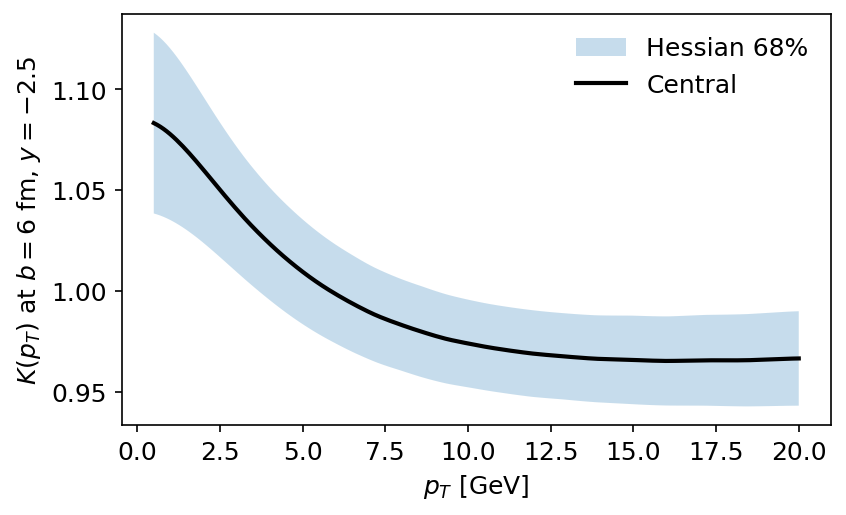

In [61]:
# K vs pT at fixed (b*, y*)
y_star, b_star = -2.5, 6.0
p_vals = np.linspace(0.5, 20.0, 200)
K_all_p, _ = epps8.K_ypt_b_sets(np.full_like(p_vals, y_star), p_vals, b_star,
                                source="nuclear", include_central=True)
Kc_p  = K_all_p[0]
Klo_p, Khi_p = epps8.hessian_symmetric(Kc_p, K_all_p[1:49])

plt.figure(figsize=(5.8,3.6))
plt.fill_between(p_vals, Klo_p, Khi_p, alpha=0.25, label="Hessian 68%")
plt.plot(p_vals, Kc_p, lw=2.0, color='k', label='Central')
plt.xlabel(r"$p_T$ [GeV]"); plt.ylabel(r"$K(p_T)$ at $b=6$ fm, $y=-2.5$")
plt.legend(frameon=False); plt.tight_layout()

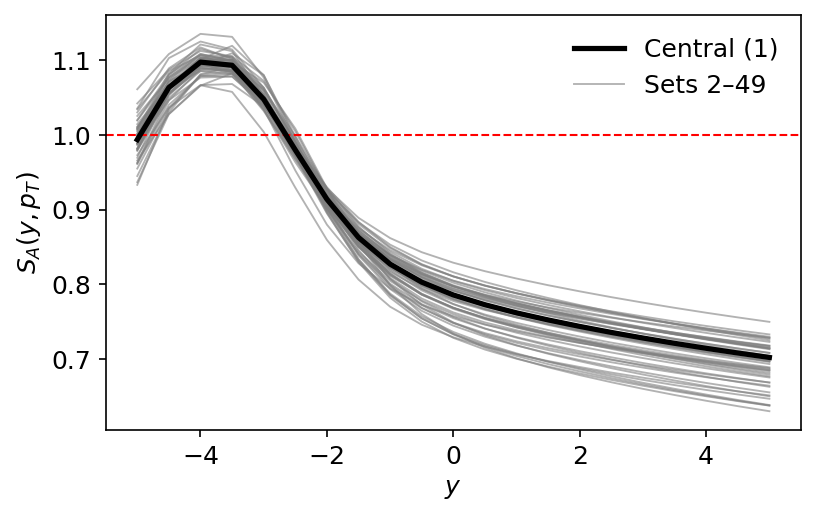

In [62]:
# S_A(y, pT=5) for sets 1..49 (central bold)
y  = np.linspace(-5, 5, 21)
pt = 5.0
plt.figure(figsize=(5.6, 3.6))
for i in range(1, 50):
    SA = epps8.SA_ypt_set(y, np.full_like(y, pt), set_id=i)
    if i == 1:
        plt.plot(y, SA, lw=2.5, color='black', label="Central (1)", zorder=5)
    else:
        plt.plot(y, SA, lw=0.9, color='gray', alpha=0.6, label="Sets 2–49" if i==2 else None)
plt.axhline(1.0, color='red', ls='--', lw=1.0)
plt.xlabel(r"$y$"); plt.ylabel(r"$S_A(y,p_T)$"); plt.legend(frameon=False); plt.tight_layout()

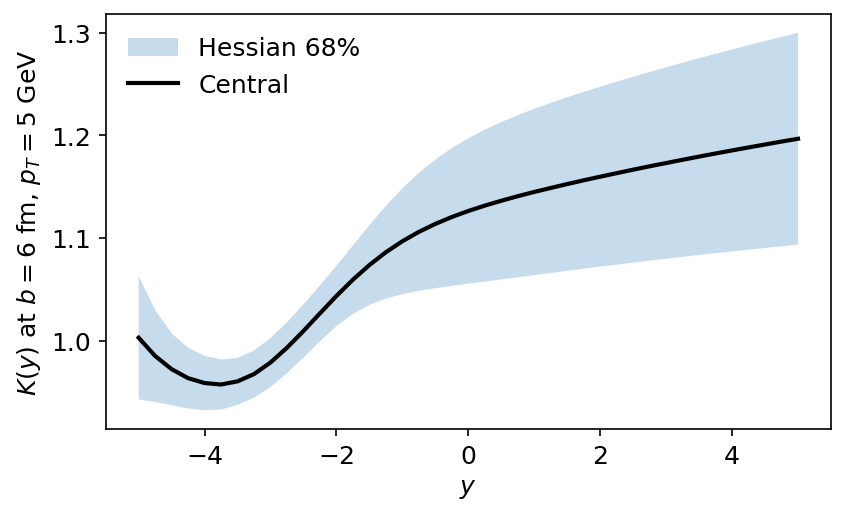

In [63]:
# K vs y at fixed (b*, pT*)
b_star, pT_star = 6.0, 5.0
y_vals = np.linspace(-5, 5, 41)
K_all_y, _ = epps8.K_ypt_b_sets(y_vals, np.full_like(y_vals, pT_star), b_star,
                                source="nuclear", include_central=True)
Kc_y  = K_all_y[0]
Klo_y, Khi_y = epps8.hessian_symmetric(Kc_y, K_all_y[1:49])

plt.figure(figsize=(5.8,3.6))
plt.fill_between(y_vals, Klo_y, Khi_y, alpha=0.25, label="Hessian 68%")
plt.plot(y_vals, Kc_y, lw=2.0, color='k', label='Central')
plt.xlabel(r"$y$"); plt.ylabel(r"$K(y)$ at $b=6$ fm, $p_T=5$ GeV"); plt.legend(frameon=False); plt.tight_layout()

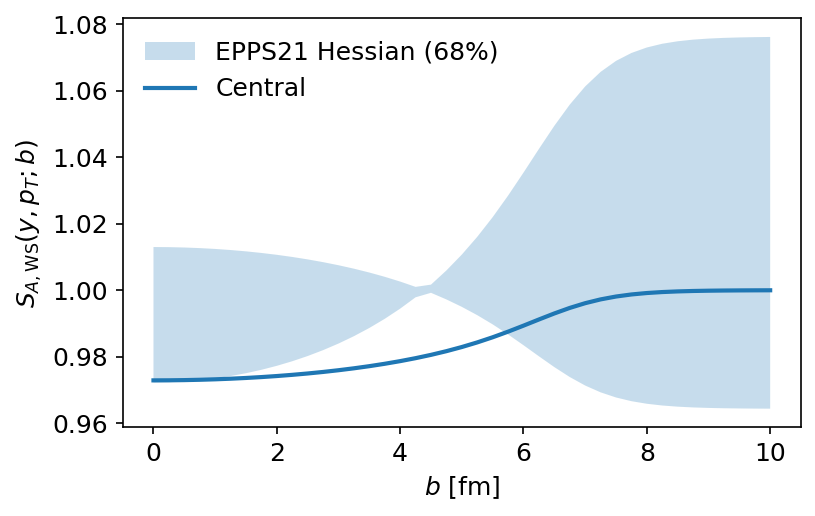

In [64]:
# S_A,WS(b; y*, pT*) with Hessian band (68%)
b_list  = np.linspace(0,10, 41)
pT_fix, y_fix = 5.0, -2.5
SAWS_c  = np.array([epps8.SAWS_ypt_b_set(y_fix, pT_fix, b, set_id=1) for b in b_list])
lo_hi   = [epps8.SAWS_band_ypt_b(y_fix, pT_fix, b) for b in b_list]
SAWS_lo, SAWS_hi = np.array(lo_hi).T

plt.figure(figsize=(5.6,3.6))
plt.fill_between(b_list, SAWS_lo, SAWS_hi, alpha=0.25, label="EPPS21 Hessian (68%)")
plt.plot(b_list, SAWS_c, lw=2, label="Central")
plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$S_{A,\mathrm{WS}}(y,p_T; b)$"); plt.legend(frameon=False); plt.tight_layout()

In [21]:
### 2) Raw R_pA (TopDrawer σ) lines — vs y and vs pT
# Helper: draw central + faded members using the aligned base grid order

def _plot_raw_members_vs_y(ax, sysX, pt_min, color, central_label, weight_mode="pa"):
    base, r0, M = ana.compute_rpa_members(sysX.df_pp, sysX.df_pa, sysX.df_errors,
                                          join="intersect", lowpt_policy="drop",
                                          pt_shift_min=0, shift_if_r_below=0.0)
    rgrid_min = base.copy(); rgrid_min["r_central"] = r0
    wtab  = RpAAnalysis._make_weight_table(rgrid_min, sysX.df_pa, df_pp=sysX.df_pp, mode=weight_mode)
    wfull = wtab["w"].to_numpy()

    yvals = np.sort(base["y"].unique()); yb = base["y"].to_numpy(); pb = base["pt"].to_numpy()

    # central
    ys_c, Rs_c = [], []
    for yy in yvals:
        m = (yb == yy) & (pb >= float(pt_min))
        if not np.any(m): continue
        R, w = r0[m], wfull[m]; g = (w>0) & np.isfinite(R)
        if np.any(g): ys_c.append(float(yy)); Rs_c.append(float(np.sum(R[g]*w[g])/np.sum(w[g])))
    if len(ys_c) >= 2: ax.plot(ys_c, Rs_c, "-", lw=2.0, color=color, label=central_label, zorder=5)

    # members
    if M.size:
        for j in range(M.shape[0]):
            ys_j, Rs_j = [], []
            for yy in yvals:
                m = (yb == yy) & (pb >= float(pt_min))
                if not np.any(m): continue
                Rj, w = M[j, m], wfull[m]; g = (w>0) & np.isfinite(Rj)
                if np.any(g): ys_j.append(float(yy)); Rs_j.append(float(np.sum(Rj[g]*w[g])/np.sum(w[g])))
            if len(ys_j) >= 2: ax.plot(ys_j, Rs_j, "-", lw=0.8, alpha=0.18, color=color, zorder=3)


def _plot_raw_members_vs_pt(ax, sysX, y_min, y_max, color, central_label, weight_mode="pa"):
    base, r0, M = ana.compute_rpa_members(sysX.df_pp, sysX.df_pa, sysX.df_errors,
                                          join="intersect", lowpt_policy="drop",
                                          pt_shift_min=0, shift_if_r_below=0.0)
    rgrid_min = base.copy(); rgrid_min["r_central"] = r0
    wtab  = RpAAnalysis._make_weight_table(rgrid_min, sysX.df_pa, df_pp=sysX.df_pp, mode=weight_mode)
    w_full = base.merge(wtab, on=["y","pt"], how="left")["w"].to_numpy()

    yb = base["y"].to_numpy(); pb = base["pt"].to_numpy()
    mY = (yb >= float(y_min)) & (yb <= float(y_max))
    pts = np.sort(np.unique(pb[mY]))

    # central line
    Rc = []
    for p in pts:
        m = mY & (pb == p)
        if not np.any(m): Rc.append(np.nan); continue
        R, w = r0[m], w_full[m]; g = (w>0) & np.isfinite(R)
        Rc.append(float(np.sum(R[g]*w[g]) / np.sum(w[g])) if np.any(g) else np.nan)
    ax.plot(pts, Rc, "-", lw=2.0, color=color, label=central_label, zorder=5)

    # members
    if M.size:
        for j in range(M.shape[0]):
            Rj_all = []
            for p in pts:
                m = mY & (pb == p)
                if not np.any(m): Rj_all.append(np.nan); continue
                Rj, w = M[j, m], w_full[m]; g = (w>0) & np.isfinite(Rj)
                Rj_all.append(float(np.sum(Rj[g]*w[g]) / np.sum(w[g])) if np.any(g) else np.nan)
            ax.plot(pts, np.asarray(Rj_all, float), "-", lw=0.8, alpha=0.18, color=color, zorder=3)

In [24]:
# Figure: raw R_pA vs y (pT thresholds) and vs pT (y-windows)
fig2 = plt.figure(figsize=(12.5, 9.0), constrained_layout=True)
sft2, sfb2 = fig2.subfigures(2, 1, height_ratios=[1.0, 1.2])

# top: vs y @ two pT thresholds
axes2_y = sft2.subplots(1, 2, sharey=True)
for ax, (ptmin, note) in zip(axes2_y, [(2.5, r"$p_T \\geq 2.5$ GeV"), (1.0, r"$p_T \\geq 1.0$ GeV")]):
    _plot_raw_members_vs_y(ax, sys5, ptmin, COL["5.02"], "5.02 TeV")
    _plot_raw_members_vs_y(ax, sys8, ptmin, COL["8.16"], "8.16 TeV")
    style_axes(ax, "y", r"$R_{pA}$", grid=False)
    ax.set_xlim(-5.0, 5.0)
    ax.set_ylim(0.2, 1.2)
    note_box(ax, note, loc="upper center")
# single legend for top
h2t, l2t = axes2_y[0].get_legend_handles_labels()
sft2.legend(h2t, l2t, loc="upper right", frameon=False, ncol=2, fontsize=11)

# bottom: vs pT in three y-windows
windows = [(-1.93, 1.93, "-1.93 < y < 1.93"), (1.5, 4.0, "1.5 < y < 4.0"), (-5.0, -2.5, "-5.0 < y < -2.5")]
axes2_pt = sfb2.subplots(1, len(windows), sharex=True, sharey=True)
if len(windows) == 1:
    axes2_pt = [axes2_pt]
for ax, (ymin, ymax, name) in zip(axes2_pt, windows):
    _plot_raw_members_vs_pt(ax, sys5, ymin, ymax, COL["5.02"], "5.02 TeV")
    _plot_raw_members_vs_pt(ax, sys8, ymin, ymax, COL["8.16"], "8.16 TeV")
    style_axes(ax, r"$p_T$ [GeV]", r"$R_{pA}$", grid=False)
    ax.set_xlim(0, 20)
    ax.set_ylim(0.35, 1.25)
    note_box(ax, fr"{name}", loc="lower right")

fig2.savefig(f"{OUTDIR}/rpa_raw_members_vs_y_ptpanels.pdf", bbox_inches="tight")
plt.show()

ValueError: 
$p_T \\geq 2.5$ GeV
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

Error in callback <function _draw_all_if_interactive at 0x71a483f67ce0> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
$p_T \\geq 2.5$ GeV
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$p_T \\geq 2.5$ GeV
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1875x1350 with 5 Axes>

In [25]:
### 3) **R_PA_nPDF(b,y,pT) = S_{AWS}/S_A** (central + band)
# Central K(b; y*, pT*) and symmetric Hessian band (68%)
y_star, pT_star = -2.5, 5.0
b_grid = np.linspace(0, 10, 41)

K_all, ids = epps8.K_ypt_b_sets(y_star, pT_star, b_grid, source="nuclear", include_central=True)
K_c  = K_all[0]
K_lo, K_hi = epps8.hessian_symmetric(K_c, K_all[1:49])

plt.figure(figsize=(5.6,3.6))
plt.fill_between(b_grid, K_lo, K_hi, alpha=0.25, label="Hessian 68%")
plt.plot(b_grid, K_c, lw=2.0, color='k', label='Central')
plt.xlabel(r"$b$ [fm]"); plt.ylabel(r"$K(b;y^*,p_T^*)=S_{AWS}/S_A$")
plt.legend(frameon=False); plt.tight_layout()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!